# Multi-Layer Perceptron Neural Network
## Weather Prediction
Using this [dataset](https://www.kaggle.com/budincsevity/szeged-weather/download) from [Kaggle](https://www.kaggle.com/budincsevity/szeged-weather) that outlines weather variables in Szeged, Hungary, I developed a multi-layer perceptron neural network model. I then compared its performance to a boosted tree and described the relative tradeoffs between complexity and accuracy.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

## Import the Dataset from CSV

In [3]:
weather_df = pd.read_csv("data/weather.csv")
weather_df.shape

(96453, 12)

In [4]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

In [5]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Data Cleaning

In [6]:
#Split date feature into usable features: hour, day, month, and year
day = []
month = []
year = []
hour = []
for date in weather_df['date']:
    year.append(int(str(date).split('-')[0]))
    month.append(int(str(date).split('-')[1]))
    day.append(int(str(date).split('-')[2].split(' ')[0]))
    hour.append(int(str(date).split(' ')[1].split(':')[0]))
    
weather_df['year'] = year
weather_df['month'] = month
weather_df['day'] = day
weather_df['hour'] = hour

In [7]:
#Drop columns that are not useful for clustering
weather_df = weather_df.drop(['date', 'summary', 'loudcover', 'dailysummary'], axis = 1)

In [8]:
#Check updated dataframe
weather_df.head()

,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,year,month,day,hour
0,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,2006,3,31,22
1,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,2006,3,31,23
2,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006,4,1,0
3,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,2006,4,1,1
4,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,2006,4,1,2


## Visualize Target Variable

In [16]:
# Replace NaNs with str
weather_df['preciptype'] = [i if pd.notnull(i) else 'null' for i in list(weather_df['preciptype'])]
weather_df['preciptype'].value_counts()

rain    85224
snow    10712
null      517
Name: preciptype, dtype: int64

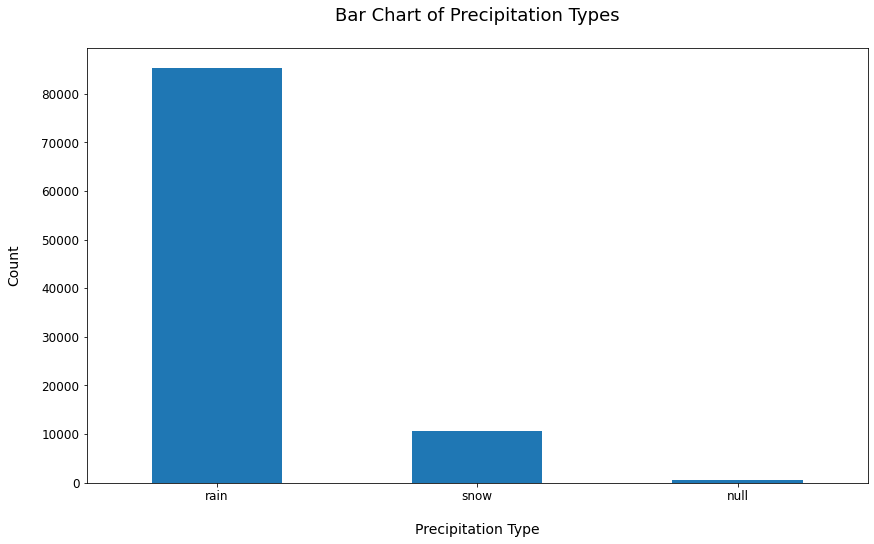

In [17]:
ax = weather_df['preciptype'].value_counts().plot(kind='bar', figsize=(14,8), fontsize = 12)
ax.set_title("Bar Chart of Precipitation Types\n", fontsize=18)
ax.set_xlabel("\nPrecipitation Type", fontsize=14)
ax.set_xticklabels(['rain', 'snow', 'null'], rotation=0)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

## Address Class Imbalance via Undersampling of Majority Label

In [18]:
weather_df = weather_df[weather_df['preciptype']!='null']
weather_df = weather_df.reset_index(drop=True)

In [19]:
X = weather_df[weather_df.columns.drop('preciptype')]
y = weather_df['preciptype']

In [20]:
unique_y = list(np.unique(y))
y = np.array([unique_y.index(i) for i in list(y)])
y

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [37]:
y_new = pd.DataFrame([item for item in y_res], columns = ['Class'])

print(len(y_new[y_new['Class']==1]))
print(len(y_new[y_new['Class']==0]))

10712
10712


In [38]:
X = X_res.copy()
y = np.array(y_new['Class'])

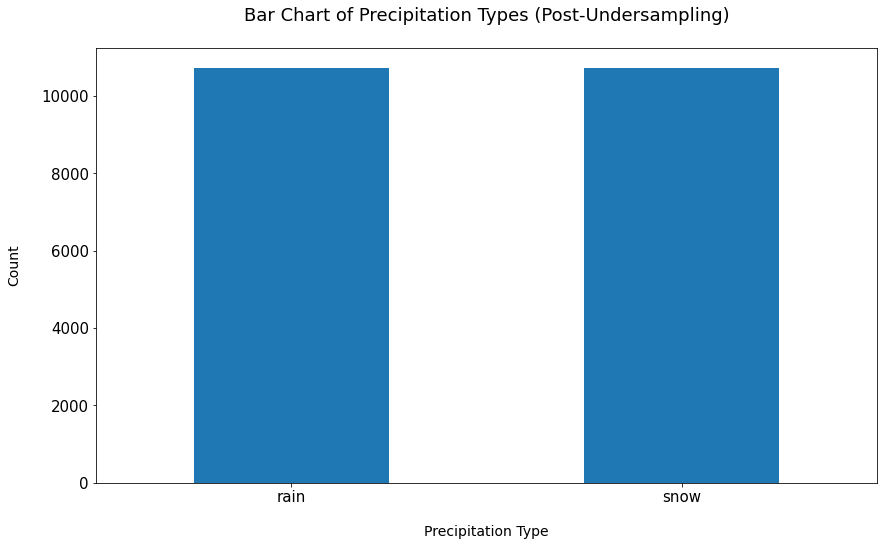

In [39]:
ax = pd.Series(y).value_counts().plot(kind='bar', figsize=(14,8), fontsize = 15)
ax.set_title("Bar Chart of Precipitation Types (Post-Undersampling)\n", fontsize=18)
ax.set_xlabel("\nPrecipitation Type", fontsize=14)
ax.set_xticklabels(unique_y, rotation=0)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

## Feature Selection

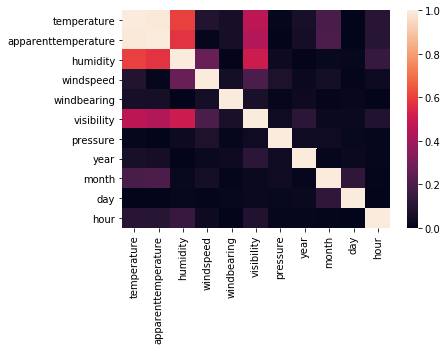

In [73]:
#Find the correlation between the existing features to see if we need to drop any
plt.figure()
sns.heatmap(abs(X.corr()))
plt.show()

In [40]:
#Drop apparenttemperature
X = X.drop('apparenttemperature', axis=1)

#preciptype is the target variable, everything else is a feature
headers = list(X.columns)

In [41]:
print(X.shape)
print(y.shape)

(21424, 10)
(21424,)


## Train-Test Split

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 450)

## Build a Default MLP Model

In [43]:
from sklearn.neural_network import MLPClassifier
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(),random_state=42)
mlp.fit(X_train,y_train)
mlp.score(X_train, y_train)

0.9900811015811891

In [44]:
from sklearn.model_selection import cross_val_score
# 5-fold CV
scores = cross_val_score(mlp, X_train, y_train, cv=5)
print('Scores: ', scores)

print('\nAccuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Scores:  [0.99183197 0.98949825 0.99387398 0.9827888  0.99124599]

Accuracy: 0.99 (+/- 0.01)


## Build an Optimized MLP Model

In [45]:
# MLP Hyperparameter tuning
mlp_opt = MLPClassifier(max_iter=200,random_state=42)

In [46]:
param_options = {
    'hidden_layer_sizes': [(1000,),(500,),(100,)],
    'activation': ['relu','logistic'],
    'solver': ['sgd', 'lbfgs'],
    'alpha': [0.001, 0.000001],
    'learning_rate': ['constant','adaptive'],
}

In [47]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp_opt, param_options, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best parameters
print('Best parameters found:\n', clf.best_params_)

KeyboardInterrupt: 

In [ ]:
mlp2 = MLPClassifier(**clf.best_params_)
mlp2.fit(X_train,y_train)
mlp2.score(X_train, y_train)

In [ ]:
# 5-fold CV
scores = cross_val_score(mlp2, X_train, y_train, cv=5)
print('Scores: ', scores)

print('\nAccuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

## Boosted Tree Model

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)

predict_train = gb.predict(X_train)
predict_test = gb.predict(X_test)


# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


In [ ]:
gb.score(X_test, y_test)

#Create Confusion Matrix (outlines Type 1 and 2 Errors)
y_pred = gb.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
feature_importance = gb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# 5-fold CV
scores = cross_val_score(gb, X_train, y_train, cv=5)
print('Scores: ', scores)

print('\nAccuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

## Conclusions

The optimized MLP model gives very high accuracy, 0.97, but with a greater than ideal level of overfitting (variance of 0.05). Interestingly, the boosted gradient model for this dataset produces perfect accuracy. Upon deeper analysis, this result makes sense, as it shows that temperature has the highest relative feature importance, at 100%. Therefore, because this dataset has perfect correlation between temperature and precipitation type, the gradient boost classifier can achieve perfect prediction results.